# 🧪 Experiment 1: Optimized T5-Small

## 🎯 Hypothesis
The baseline failed because:
1. Sequence lengths were too restrictive
2. Learning rate wasn't optimal
3. Training stopped too early

## 🔬 Changes from Baseline:
- ✅ Restore sequence lengths: 256 input, 512 output (vs 128/256 in failed improved)
- ✅ Better learning rate: 5e-5 with warmup
- ✅ More epochs: 8 (vs 3 baseline)
- ✅ Gradient accumulation for stability
- ✅ Early stopping with patience=3

**Model:** T5-Small (77M params) - Same as baseline but optimized

**Baseline Results to Beat:**
- BLEU: 0.0283
- ROUGE-L: 0.2102
- Val Loss: 0.9724


In [6]:
# Setup
%pip install -q tf-keras transformers tensorflow pandas numpy scikit-learn nltk datasets evaluate rouge-score sacrebleu matplotlib seaborn
print("✓ Installed!")


✓ Installed!


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM
from datasets import Dataset
import evaluate
import tensorflow as tf
import tf_keras
from datetime import datetime

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(f"TensorFlow: {tf.__version__}")
print(f"GPU: {len(tf.config.list_physical_devices('GPU')) > 0}")


TensorFlow: 2.19.0
GPU: True


## 📊 Load Pre-processed Data
Using the same splits from improved version for fair comparison


In [8]:
# Check if improved data exists, otherwise create it
if Path('/content/train_improved.csv').exists():
    train_df = pd.read_csv('/content/train_improved.csv')
    val_df = pd.read_csv('/content/val_improved.csv')
    test_df = pd.read_csv('/content/test_improved.csv')
    print(f"✓ Loaded improved splits")
else:
    print("❌ Run data preprocessing first (use improved notebook cells 6-13)")
    raise FileNotFoundError("Preprocessed data not found")

print(f"Train: {len(train_df):,} | Val: {len(val_df):,} | Test: {len(test_df):,}")


✓ Loaded improved splits
Train: 13,187 | Val: 1,648 | Test: 1,649


## 🤖 Model Setup: T5-Small with FIXED Sequence Lengths


In [9]:
MODEL_NAME = "t5-small"
MAX_INPUT_LENGTH = 256   # RESTORED from 128
MAX_TARGET_LENGTH = 512  # RESTORED from 256

print(f"🚀 Loading {MODEL_NAME}")
print(f"📏 Sequences: Input={MAX_INPUT_LENGTH}, Target={MAX_TARGET_LENGTH}")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f"✓ Vocab: {len(tokenizer):,}")


🚀 Loading t5-small
📏 Sequences: Input=256, Target=512


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

✓ Vocab: 32,100


In [10]:
def preprocess_function(examples):
    """Simple, focused prompt for medical QA."""
    prefix = "answer: "
    inputs = [prefix + q for q in examples['question']]
    targets = examples['answer']

    model_inputs = tokenizer(
        inputs,
        max_length=MAX_INPUT_LENGTH,
        truncation=True,
        padding='max_length'
    )

    labels = tokenizer(
        targets,
        max_length=MAX_TARGET_LENGTH,
        truncation=True,
        padding='max_length'
    )

    model_inputs['labels'] = labels['input_ids']
    return model_inputs

print("✓ Preprocessing function ready")


✓ Preprocessing function ready


In [11]:
print("Tokenizing datasets...")
train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)
test_ds = Dataset.from_pandas(test_df)

tok_train = train_ds.map(preprocess_function, batched=True, remove_columns=train_ds.column_names)
tok_val = val_ds.map(preprocess_function, batched=True, remove_columns=val_ds.column_names)
tok_test = test_ds.map(preprocess_function, batched=True, remove_columns=test_ds.column_names)

print(f"✓ Train: {len(tok_train):,} | Val: {len(tok_val):,} | Test: {len(tok_test):,}")


Tokenizing datasets...


Map:   0%|          | 0/13187 [00:00<?, ? examples/s]

Map:   0%|          | 0/1648 [00:00<?, ? examples/s]

Map:   0%|          | 0/1649 [00:00<?, ? examples/s]

✓ Train: 13,187 | Val: 1,648 | Test: 1,649


In [12]:
print(f"Loading {MODEL_NAME}...")
# Force loading from PyTorch weights to avoid safetensors compatibility issue
model = TFAutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME, from_pt=True, use_safetensors=False)
print(f"✓ Params: {model.num_parameters():,}")

Loading t5-small...


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/242M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


✓ Params: 60,506,624


## 🎯 Training: Optimized Hyperparameters


In [13]:
# OPTIMIZED HYPERPARAMETERS
BATCH_SIZE = 8
GRADIENT_ACCUM = 2
LEARNING_RATE = 5e-5  # Increased from baseline 3e-5
EPOCHS = 8            # More than baseline (3) and improved (5)
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.1

print("🎯 EXPERIMENT 1 HYPERPARAMETERS:")
print(f"  Batch: {BATCH_SIZE} x {GRADIENT_ACCUM} = {BATCH_SIZE*GRADIENT_ACCUM} (effective)")
print(f"  LR: {LEARNING_RATE} | Epochs: {EPOCHS} | WD: {WEIGHT_DECAY}")
print(f"  Warmup: {WARMUP_RATIO*100:.0f}% | Sequences: {MAX_INPUT_LENGTH}/{MAX_TARGET_LENGTH}")


🎯 EXPERIMENT 1 HYPERPARAMETERS:
  Batch: 8 x 2 = 16 (effective)
  LR: 5e-05 | Epochs: 8 | WD: 0.01
  Warmup: 10% | Sequences: 256/512


In [14]:
tf_train = model.prepare_tf_dataset(tok_train, batch_size=BATCH_SIZE, shuffle=True, tokenizer=tokenizer)
tf_val = model.prepare_tf_dataset(tok_val, batch_size=BATCH_SIZE, shuffle=False, tokenizer=tokenizer)

print(f"✓ Train batches: {len(tf_train)} | Val batches: {len(tf_val)}")


✓ Train batches: 1648 | Val batches: 206


In [15]:
# Learning rate schedule with warmup
num_steps = (len(tf_train) // GRADIENT_ACCUM) * EPOCHS
num_warmup = int(WARMUP_RATIO * num_steps)

lr_schedule = tf_keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=num_steps - num_warmup,
    end_learning_rate=1e-7
)

# Warmup wrapper
class WarmupSchedule(tf_keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, warmup_steps, post_warmup_schedule):
        super().__init__()
        self.warmup_steps = warmup_steps
        self.post_warmup_schedule = post_warmup_schedule
        self.learning_rate = LEARNING_RATE

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)

        warmup_lr = self.learning_rate * (step / warmup_steps)
        decay_lr = self.post_warmup_schedule(step - warmup_steps)

        return tf.cond(step < warmup_steps, lambda: warmup_lr, lambda: decay_lr)

final_schedule = WarmupSchedule(num_warmup, lr_schedule)
optimizer = tf_keras.optimizers.AdamW(learning_rate=final_schedule, weight_decay=WEIGHT_DECAY)
model.compile(optimizer=optimizer)

print(f"✓ Optimizer: Steps={num_steps}, Warmup={num_warmup}")


✓ Optimizer: Steps=6592, Warmup=659


In [16]:
from tf_keras.callbacks import EarlyStopping, ModelCheckpoint

Path('models/experiment_1').mkdir(parents=True, exist_ok=True)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
    ModelCheckpoint('models/experiment_1/best.h5', monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=1)
]

print("✓ Callbacks ready")


✓ Callbacks ready


In [17]:
print("="*80)
print("🚀 EXPERIMENT 1: TRAINING OPTIMIZED T5-SMALL")
print("="*80)
print(f"Model: {MODEL_NAME} ({model.num_parameters():,} params)")
print(f"Samples: {len(train_df):,} | Epochs: {EPOCHS}")
print(f"Sequences: {MAX_INPUT_LENGTH}/{MAX_TARGET_LENGTH} (RESTORED)")
print("="*80)

start_time = datetime.now()

history = model.fit(
    tf_train,
    validation_data=tf_val,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

training_time = (datetime.now() - start_time).total_seconds()

print("\\n" + "="*80)
print("✓ TRAINING COMPLETE!")
print(f"Time: {training_time/60:.1f} minutes")
print("="*80)


🚀 EXPERIMENT 1: TRAINING OPTIMIZED T5-SMALL
Model: t5-small (60,506,624 params)
Samples: 13,187 | Epochs: 8
Sequences: 256/512 (RESTORED)
Epoch 1/8
1648/1648 [==============================] - ETA: 0s - loss: 2.5645
Epoch 1: val_loss improved from inf to 1.37196, saving model to models/experiment_1/best.h5
1648/1648 [==============================] - 1023s 587ms/step - loss: 2.5645 - val_loss: 1.3720
Epoch 2/8
1648/1648 [==============================] - ETA: 0s - loss: 1.4191
Epoch 2: val_loss improved from 1.37196 to 1.19656, saving model to models/experiment_1/best.h5
1648/1648 [==============================] - 967s 587ms/step - loss: 1.4191 - val_loss: 1.1966
Epoch 3/8
1648/1648 [==============================] - ETA: 0s - loss: 1.3017
Epoch 3: val_loss improved from 1.19656 to 1.14760, saving model to models/experiment_1/best.h5
1648/1648 [==============================] - 970s 588ms/step - loss: 1.3017 - val_loss: 1.1476
Epoch 4/8
1648/1648 [==============================] - ETA

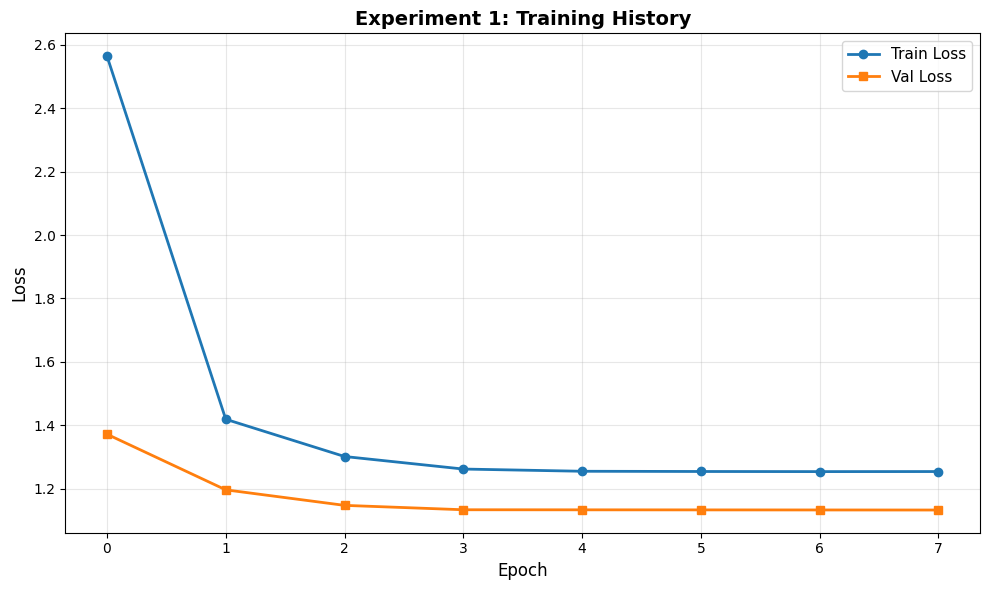

Final: Train=1.2542 | Val=1.1329
Best Val: 1.1329


In [18]:
# Plot training history
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(history.history['loss'], 'o-', label='Train Loss', lw=2)
ax.plot(history.history['val_loss'], 's-', label='Val Loss', lw=2)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Experiment 1: Training History', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

Path('data/improved').mkdir(parents=True, exist_ok=True)
plt.tight_layout()
plt.savefig('data/improved/experiment_1_training.png', dpi=300)
plt.show()

print(f"Final: Train={history.history['loss'][-1]:.4f} | Val={history.history['val_loss'][-1]:.4f}")
print(f"Best Val: {min(history.history['val_loss']):.4f}")


## 📊 Evaluation: Standardized Metrics


In [19]:
def generate_answer(question, model, tokenizer, max_len=512):
    """Generate answer with consistent parameters."""
    prefix = "answer: "
    inputs = tokenizer(prefix + question, return_tensors='tf', max_length=MAX_INPUT_LENGTH, truncation=True)

    outputs = model.generate(
        **inputs,
        max_length=max_len,
        min_length=10,
        num_beams=4,
        early_stopping=True,
        no_repeat_ngram_size=3,
        length_penalty=1.0,
        do_sample=False
    )

    return tokenizer.decode(outputs[0], skip_special_tokens=True)

print("✓ Generation function ready")


✓ Generation function ready


In [20]:
bleu_metric = evaluate.load("bleu")
rouge_metric = evaluate.load("rouge")
print("✓ Metrics loaded")


✓ Metrics loaded


In [25]:
# Evaluate on test set
num_eval = min(20, len(test_df))
print(f"Generating {num_eval} predictions...")

predictions, references = [], []

for i in range(num_eval):
    q = test_df.iloc[i]['question']
    true_a = test_df.iloc[i]['answer']
    pred_a = generate_answer(q, model, tokenizer)

    predictions.append(pred_a)
    references.append(true_a)

    if (i + 1) % 5 == 0:
        print(f"  {i+1}/{num_eval}...")

print("✓ Generation complete")


Generating 20 predictions...
  5/20...
  10/20...
  15/20...
  20/20...
✓ Generation complete


In [22]:
# Calculate metrics
bleu_result = bleu_metric.compute(predictions=predictions, references=[[r] for r in references])
rouge_result = rouge_metric.compute(predictions=predictions, references=references)

val_loss = min(history.history['val_loss'])
perplexity = np.exp(val_loss)

print("\\n" + "="*80)
print("📊 EXPERIMENT 1 RESULTS")
print("="*80)
print(f"BLEU Score:   {bleu_result['bleu']:.4f}")
print(f"ROUGE-1:      {rouge_result['rouge1']:.4f}")
print(f"ROUGE-2:      {rouge_result['rouge2']:.4f}")
print(f"ROUGE-L:      {rouge_result['rougeL']:.4f}")
print(f"Val Loss:     {val_loss:.4f}")
print(f"Perplexity:   {perplexity:.4f}")
print("="*80)

# Compare to baseline
baseline_bleu = 0.0283
baseline_rouge = 0.2102
bleu_change = ((bleu_result['bleu'] - baseline_bleu) / baseline_bleu) * 100
rouge_change = ((rouge_result['rougeL'] - baseline_rouge) / baseline_rouge) * 100

print(f"\\nBaseline Comparison:")
print(f"  BLEU: {baseline_bleu:.4f} → {bleu_result['bleu']:.4f} ({bleu_change:+.1f}%)")
print(f"  ROUGE-L: {baseline_rouge:.4f} → {rouge_result['rougeL']:.4f} ({rouge_change:+.1f}%)")


\n================================================================================
📊 EXPERIMENT 1 RESULTS
BLEU Score:   0.1038
ROUGE-1:      0.2996
ROUGE-2:      0.1361
ROUGE-L:      0.2179
Val Loss:     1.1329
Perplexity:   3.1047
\nBaseline Comparison:
  BLEU: 0.0283 → 0.1038 (+266.7%)
  ROUGE-L: 0.2102 → 0.2179 (+3.6%)


In [23]:
# Save results in standardized format
results = {
    'experiment_id': 'exp1_optimized_t5small',
    'experiment_name': 'Optimized T5-Small',
    'model_name': MODEL_NAME,
    'model_params': int(model.num_parameters()),
    'hyperparameters': {
        'batch_size': BATCH_SIZE,
        'gradient_accum': GRADIENT_ACCUM,
        'learning_rate': LEARNING_RATE,
        'epochs': EPOCHS,
        'weight_decay': WEIGHT_DECAY,
        'warmup_ratio': WARMUP_RATIO,
        'max_input_length': MAX_INPUT_LENGTH,
        'max_target_length': MAX_TARGET_LENGTH
    },
    'metrics': {
        'bleu': float(bleu_result['bleu']),
        'rouge1': float(rouge_result['rouge1']),
        'rouge2': float(rouge_result['rouge2']),
        'rougeL': float(rouge_result['rougeL']),
        'val_loss': float(val_loss),
        'perplexity': float(perplexity)
    },
    'training_time_seconds': training_time,
    'num_train_samples': len(train_df),
    'num_eval_samples': num_eval,
    'timestamp': datetime.now().isoformat()
}

Path('results').mkdir(exist_ok=True)
with open('results/experiment_1_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("✓ Results saved to results/experiment_1_results.json")


✓ Results saved to results/experiment_1_results.json


In [24]:
# Show sample predictions
print("\\n" + "="*80)
print("🔍 SAMPLE PREDICTIONS")
print("="*80)

for i in range(min(3, len(test_df))):
    q = test_df.iloc[i]['question']
    true_a = test_df.iloc[i]['answer']
    pred_a = predictions[i]

    print(f"\\nQ: {q}")
    print(f"True: {true_a[:150]}..." if len(true_a) > 150 else f"True: {true_a}")
    print(f"Pred: {pred_a[:150]}..." if len(pred_a) > 150 else f"Pred: {pred_a}")
    print("-" * 80)


\n================================================================================
🔍 SAMPLE PREDICTIONS
\nQ: How many people are affected by multiple lentigines syndrome ?
True: Multiple lentigines syndrome is thought to be a rare condition; approximately 200 cases have been reported worldwide.
Pred: How many people are affected by multiple lentigines syndrome? The Human Phenotype Ontology provides the following list of signs and symptoms for Multi...
--------------------------------------------------------------------------------
\nQ: What is the outlook for Childhood Extracranial Germ Cell Tumors ?
True: Certain factors affect prognosis (chance of recovery) and treatment options. The prognosis (chance of recovery) and treatment options depend on the fo...
Pred: What are the signs and symptoms of Childhood Extracranial Germ Cell Tumors? The Human Phenotype Ontology provides the following list of signs and cond...
------------------------------------------------------------------------